In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from matplotlib import gridspec

import numpy as np
from numpy import linalg

def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../src")   
add_relative_to_current_source_file_path_to_sys_path("../../logs")      

import spooky.coords
import log_graph
import replay.main

/Users/njoubert/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
LOG = "/Users/njoubert/Code/spooky/logs/state0001109.pickle"

'''
Setting up Tableau Colors. 
http://tableaufriction.blogspot.ca/2012/11/finally-you-can-use-tableau-data-colors.html
'''
t10 = np.array([[31,119,180],[255,127,14],[44,160,44],[214,39,40],[148,103,189]])
t10 = t10/255.0

t10l = np.array([[174,199,232],[255,187,120],[152,223,138],[255,152,150],[197,176,213]])
t10l = t10l/255.0

In [3]:
replay.main.generate_fake_SPP_GPS_Baselines

<function replay.main.generate_fake_SPP_GPS_Baselines>

In [4]:
l = log_graph.loadLog(LOG)

In [5]:
for nextState in l:
    replay.main.generate_fake_SPP_GPS_Baselines(nextState,verbose=False)
    

In [22]:
errorNED = []
errorNE  = []
for nextState in l:
    if "base_station" in nextState and "surveyed_pos" in nextState["base_station"]:
        for p in ['192.168.2.51','192.168.2.52']:
            person = nextState[p]
            real_baseline = np.array([float(person["MsgBaselineNED"]['n']), float(person["MsgBaselineNED"]['e']), float(person["MsgBaselineNED"]['d'])])
            calib_rel_ned = np.array([float(person["SPPGPSBaseline_calibrated"]['n']),float(person["SPPGPSBaseline_calibrated"]['e']),float(person["SPPGPSBaseline_calibrated"]['d'])])
            calib_rel_ned = np.array([float(person["SPPGPSBaseline"]['n']),float(person["SPPGPSBaseline"]['e']),float(person["SPPGPSBaseline"]['d'])])
            
            localError = linalg.norm(real_baseline - calib_rel_ned)
            errorNED.append([localError])
            localNEError = linalg.norm(real_baseline[0:1] - calib_rel_ned[0:1])
            errorNE.append([localNEError])
            

[461.53982839658846]
[239.96665662250507]
51


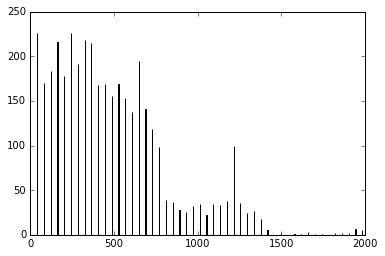

In [21]:
print errorNED[1000]
print errorNE[1000]
n, bins = np.histogram(errorNE, bins=50, density=None)


print len(bins)

fig, ax = plt.subplots()
rects1 = ax.bar(bins[0:50], n, 1, color='r')

In [ ]:
# the histogram of the data
#n, bins, patches = plt.hist(errorNE, 50, normed=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
#y = mlab.normpdf( bins, mu, sigma)
#l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
plt.grid(True)

plt.show()

In [ ]:
errorNE